# ACO - Vehicle Routing Problem with Capacity and Time Windows

In [1]:
from math import dist
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

## Prepare data and graph, visualization of data points

In [2]:
class Graph:
    def __init__(self, x, y, n_depots) -> None:
        self.n = n = len(x)
        self.x = np.array(x, dtype=float)
        self.y = np.array(y, dtype=float)
        self.edges = np.zeros(shape=(n,n), dtype=float)

        for i in range(self.n):
            for j in range(self.n):
                self.edges[i,j] = dist([x[i], y[i]], [x[j], y[j]])

        xf = 10000
        # high distance from one point to itself
        for i in range(self.n):
            self.edges[i,i] = xf
            
        # high distance from one depot to another depot
        for i in range(n_depots):
            for j in range(n_depots):
                self.edges[i,j] = xf

In [3]:
def get_location_data():
    with open('rcdata/r103.txt', 'r', encoding = 'utf-8') as f:
        [f.readline() for i in range(4)]
        n_locations = 100
        max_vehicles, max_capacity = [int(x) for x in f.readline().split()]
        data = []
        [f.readline() for i in range(4)]
        for i in range(n_locations + 1):
            data.append([float(x) for x in f.readline().split()[1:]])

    # uncomment to see plot
    # data = np.array(data)
    # dataT = data.T
    # a = pd.DataFrame({'x':dataT[0], 'y':dataT[1] , 'd':dataT[2]})
    # sns.scatterplot(data=a, x='x', y='y', size='d', palette="deep")
    return data, n_locations, max_vehicles, max_capacity

In [4]:
def insert_duplicate_depots(depots_to_add):
    data, n_locations, max_vehicles, max_capacity = get_location_data()
    data = np.append(np.repeat([data[0]], depots_to_add, axis=0), data, axis=0)
    return data, n_locations, max_vehicles, max_capacity

In [5]:
def create_graph(n_vehicles):
    n_depots = n_vehicles + 1 # IMPORTANT
    data, n_locations, max_vehicles, max_capacity = insert_duplicate_depots(n_depots - 1)
    dataT = data.T
    graph = Graph(dataT[0], dataT[1], n_depots)
    return data, graph, n_locations, n_depots, max_vehicles, max_capacity 

## Objective function

In [6]:
def maco_objective(tour, n_locations, n_depots, data, graph, max_capacity):
    
    curr_time, curr_dist, curr_load = 0, 0, 0

    for i in range(len(tour)-1):

        ni, nj = tour[i], tour[i+1]
        tij = dist([data[ni,0], data[ni,1]], [data[nj,0], data[nj,1]])
        curr_dist += tij

        # not necessary, just checking correctness
        if nj < n_depots:   # destination location is a depot
            curr_time, curr_load = 0, 0

        else:               # destination location is a client location
            curr_load += data[nj,2]
            curr_time = max(curr_time + tij, data[nj,3])
            assert(data[nj,3] <= curr_time <= data[nj,4]), 'time'
            assert(curr_load <= max_capacity), 'capacity'
            curr_time += data[nj,5]
        
    assert(tour[0] < n_depots and tour[-1] < n_depots), 'depots'
    
    return curr_dist

## Ant Definition

In [7]:
class Ant:
    def __init__(self, tour, n_locations, n_depots, data, graph, max_capacity) -> None:
        self.tour = tour
        self.cost = maco_objective(tour, n_locations, n_depots, data, graph, max_capacity)
        self.veh = sum([x < n_depots for x in tour]) - 1 # CHECK LATER
        # clients visited
        self.visi = len(set(tour)) - (self.veh + 1) # CHECK LATER

    def __repr__(self) -> str:
        return f'Ant(tour={self.tour}, o={self.cost}, veh={self.veh}, visi={self.visi})'

    def __lt__(self, other):
        return self.cost < other.cost

In [8]:
def feasible_initial_solution(n_locations, n_depots, graph, data, max_capacity):
    tour = [0]
    vis = np.zeros(n_locations + n_depots)
    vis[0] = 1
    load, curr_time = 0, 0
    next_depot = 1

    while np.sum(vis[-n_locations:]) < n_locations: # while all client locations are yet to be visited
        last = tour[-1]
        mins = np.argsort(graph.edges[last])
        # print(graph.edges[last])
        # print(mins)
        # print(tour)
        for x in mins:
            # considering only unvisited client locations
            if (x >= n_depots and not vis[x] and curr_time + graph.edges[last,x] <= data[x,4]
                and load + data[x, 2] <= max_capacity):
                curr_time = max(curr_time + graph.edges[last][x], data[x, 3])
                curr_time += data[x,5]
                load += data[x, 2]
                tour.append(x)
                vis[x] = 1
                break
        else:
            # if no valid unvisited client locations, return to depot and start new cycle
            curr_time = 0
            load = 0
            tour.append(next_depot)
            vis[next_depot] = 1
            next_depot += 1 
    if tour[-1] >= n_depots:
        tour.append(next_depot)
    sol = Ant(tour, n_locations, n_depots, data, graph, max_capacity)
    return sol

n_vehicles = 30
data, graph, n_locations, n_depots, max_vehicles, max_capacity = create_graph(n_vehicles)
psi_gb = feasible_initial_solution(n_locations, n_depots, graph, data, max_capacity)
print(psi_gb)

Ant(tour=[0, 83, 88, 1, 57, 58, 56, 42, 110, 2, 119, 36, 124, 125, 127, 89, 123, 126, 3, 70, 51, 103, 102, 104, 105, 32, 4, 43, 67, 128, 5, 82, 48, 90, 113, 114, 35, 91, 115, 121, 130, 6, 99, 31, 80, 107, 33, 7, 106, 98, 59, 54, 8, 61, 118, 37, 112, 78, 77, 49, 93, 9, 129, 46, 116, 47, 10, 122, 117, 87, 73, 44, 11, 100, 12, 84, 85, 55, 13, 63, 111, 39, 81, 50, 62, 120, 14, 34, 15, 60, 40, 101, 16, 72, 45, 71, 86, 17, 92, 41, 79, 76, 18, 109, 64, 65, 19, 38, 20, 52, 21, 75, 74, 68, 22, 108, 96, 23, 69, 53, 97, 24, 66, 94, 25, 95, 26], o=1966.5661118342036, veh=26, visi=100)


## Local Search Functions

In [9]:
def split_into_routes(tour, n_vehicles):
    routes = []
    cur_route = [tour[0]]
    for x in tour[1:]:
        if x <= n_vehicles:
            cur_route.append(x)
            routes.append(cur_route)
            cur_route = [x]
        else:
            cur_route.append(x)
    return routes

In [10]:
def merge_into_tour(routes, n_vehicles):
    tour = [0]
    for route in routes:
        for x in route[1:]:
            tour.append(x)
    dep = 1
    for i in range(1, len(tour)):
        if tour[i] == 0:
            tour[i] = dep
            dep += 1
    return tour

In [11]:
import itertools

def two_opt(a, i, j):
    if i == 0:
        return a[j:i:-1] + [a[i]] + a[j + 1:]
    return a[:i] + a[j:i - 1:-1] + a[j + 1:]


def cross(a, b, i, j):
    return a[:i] + b[j:], b[:j] + a[i:]


def insertion(a, b, i, j):
    # print(a, b, i, j)
    if len(a) == 0:
        return a, b
    while i >= len(a):
        i -= len(a)
    return a[:i] + a[i + 1:], b[:j] + [a[i]] + b[j:]


def swap(a, b, i, j):
    # print(a, b, i, j)
    if i >= len(a) or j >= len(b):
        return a, b
    a, b = a.copy(), b.copy()
    a[i], b[j] = b[j], a[i]
    return a, b

In [12]:
def valid_route_distance(route, data, graph, max_capacity):
    
    curr_time, curr_dist, curr_load = 0, 0, 0

    for i in range(len(route)-1):

        ni, nj = route[i], route[i+1]
        tij = dist([data[ni,0], data[ni,1]], [data[nj,0], data[nj,1]])
        curr_dist += tij
        curr_load += data[nj,2]
        curr_time = max(curr_time + tij, data[nj,3])
        if not (data[nj,3] <= curr_time <= data[nj,4]):
            return False, 10000
        if not(curr_load <= max_capacity):
            return False, 10000
        curr_time += data[nj,5]
        
    return True, curr_dist

In [13]:
def local_search(tour, n_vehicles, data, graph, max_capacity):
    routes = split_into_routes(tour, n_vehicles)

    can_impr = True
    while can_impr:
        can_impr = False
        
        for i, j in itertools.combinations(range(len(routes)), 2):

            vri, dri = valid_route_distance(routes[i], data, graph, max_capacity)
            vrj, drj = valid_route_distance(routes[j], data, graph, max_capacity)

            for k, l in itertools.product(range(len(routes[i])), range(len(routes[j]))):
                for func in [cross, insertion, swap]:
                    c1, c2 = func(routes[i][1:-1], routes[j][1:-1], k, l)
                    n1, n2 = [0] + c1 + [0], [0] + c2 + [0]

                    vn1, dn1 = valid_route_distance(n1, data, graph, max_capacity)
                    vn2, dn2 = valid_route_distance(n2, data, graph, max_capacity)

                    if vn1 and vn2:
                        if dn1 + dn2 < dri + drj:
                            routes[i] = n1
                            routes[j] = n2
                            can_impr = True
                            
    return merge_into_tour(routes, n_vehicles)

## Create new ant

In [14]:
def new_active_ant(local, incom, n_locations, n_depots, n_vehicles, data, graph, tau, tau0, beta, max_capacity, rho):

    # print(data.shape, graph.edges.shape)
    inc = incom.copy()

    tour = [np.random.choice(n_depots)]
    curr_time, curr_load = 0, 0

    vis = np.zeros(n_locations + n_depots)
    vis[tour[0]] = 1
    eta = np.full(n_locations + n_depots, 0.00001)

    # first insertion of nodes by ACO
    feasible_node = True
    while feasible_node:

        feasible_node = False
        last = tour[-1]
        for x in range(n_locations + n_depots):
            if (not vis[x] and curr_time + graph.edges[last,x] <= data[x,4]
                    and curr_load + data[x, 2] <= max_capacity):
                feasible_node = True
                deliv_time = max(curr_time + graph.edges[last,x], data[x, 3])
                delta_time = deliv_time - curr_time
                distance = delta_time * (data[x,4] - curr_time)
                # print(distance)
                distance = max(1, distance - inc[x])
                eta[x] = 1 / distance
            else:
                eta[x] = 0

        if not feasible_node:
            break

        probs = (tau[last]) * (eta ** beta)
        probs = probs / np.sum(probs)
        
        next = np.random.choice(n_locations + n_depots, p=probs)
        tour.append(next)
        vis[next] = 1

        curr_time = max(curr_time + graph.edges[last][x], data[x, 3])
        curr_time += data[x,5]

        curr_load += data[x, 2]
        # print('A', tour)

        tau[last][next] = (1 - rho) * tau[last][next] + rho * tau0
    
    # print('B', tour)

    # there still may remain some non inserted nodes
    for x in range(n_locations + n_depots):
        if not vis[x]:
            for g in range(1, len(tour) + 1):
                tc = tour.copy()
                tc.insert(g, x)
                if valid_tour(tc, n_locations, n_depots, data, graph, max_capacity):
                    tour = tc
                    vis[x] = 1
                    break
    
    tour = local_search(tour, n_vehicles, data, graph, max_capacity)
    sol = Ant(tour, n_locations, n_depots, data, graph, max_capacity)
    return sol

## ACO Time function

In [15]:
def valid_tour(tour, n_locations, n_depots, data, graph, max_capacity):
    
    curr_time, curr_dist, curr_load = 0, 0, 0

    for i in range(len(tour)-1):

        ni, nj = tour[i], tour[i+1]
        tij = dist([data[ni,0], data[ni,1]], [data[nj,0], data[nj,1]])
        curr_dist += tij

        # not necessary, just checking correctness
        if nj < n_depots:   # destination location is a depot
            curr_time, curr_load = 0, 0

        else:               # destination location is a client location
            curr_load += data[nj,2]
            curr_time = max(curr_time + tij, data[nj,3])
            if not (data[nj,3] <= curr_time <= data[nj,4]):
                return False
            if not(curr_load <= max_capacity):
                return False
            curr_time += data[nj,5]
        
    if not (tour[0] < n_depots and tour[-1] < n_depots):
        return False    
        
    return True

In [16]:
# def aco_time(n_vehicles, n_ants, psi_gb, beta, rho):
def aco_time(n_vehicles, n_ants, beta, rho):
    global psi_gb

    psi_gb.cost = 10000
    n_depots = n_vehicles + 1
    data, graph, n_locations, n_depots, max_vehicles, max_capacity = create_graph(n_vehicles)
    tau0 = 10/np.sum(graph.edges)
    tau = np.full(graph.edges.shape, tau0)

    incom = np.zeros(n_locations + n_depots)
    for i in tqdm(range(10)):
        ants = [None for i in range(n_ants)]

        for i in range(n_ants):
            local = False
            ants[i] = new_active_ant(local, incom, n_locations, n_depots, 
                                    n_vehicles, data, graph, tau, tau0, 
                                    beta, max_capacity, rho)
 
        for i in range(n_ants):
            if len(ants[i].tour) == n_locations + n_depots and ants[i].cost < psi_gb.cost:
                psi_gb = ants[i]
            
        # updating tau values
        tau = (1-rho) * tau
        # print(psi_gb)
        for j in range(len(psi_gb.tour) - 1):
            cur, nxt = psi_gb.tour[j:j+2]
            if cur < tau.shape[0] and nxt < tau.shape[0]:
                tau[cur][nxt] += 1/psi_gb.cost
                tau[nxt][cur] += 1/psi_gb.cost

    return psi_gb

In [17]:
aco_time(20, 10, 1, 0.1)

100%|██████████| 10/10 [15:28<00:00, 92.84s/it]


Ant(tour=[0, 56, 84, 69, 67, 68, 39, 102, 1, 96, 99, 44, 75, 45, 74, 2, 60, 73, 3, 42, 94, 93, 92, 41, 4, 5, 108, 28, 38, 6, 7, 8, 46, 59, 43, 87, 95, 76, 24, 9, 109, 25, 81, 105, 119, 26, 10, 11, 47, 89, 50, 40, 86, 52, 90, 21, 12, 70, 53, 101, 54, 98, 49, 88, 100, 32, 13, 114, 116, 115, 117, 107, 33, 14, 71, 85, 91, 29, 55, 23, 97, 48, 15, 62, 63, 35, 61, 77, 22, 78, 16, 17, 72, 27, 82, 31, 83, 110, 30, 51, 18, 112, 118, 34, 64, 58, 106, 36, 111, 120, 57, 19, 103, 65, 66, 80, 104, 37, 113, 79, 20], o=1271.5418506401709, veh=20, visi=100)

In [20]:
best_tour = [0, 56, 84, 69, 67, 68, 39, 102, 1, 96, 99, 44, 75, 45, 74, 2, 60, 73, 3, 42, 94, 93, 92, 41, 4, 5, 108, 28, 38, 6, 7, 8, 46, 59, 43, 87, 95, 76, 24, 9, 109, 25, 81, 105, 119, 26, 10, 11, 47, 89, 50, 40, 86, 52, 90, 21, 12, 70, 53, 101, 54, 98, 49, 88, 100, 32, 13, 114, 116, 115, 117, 107, 33, 14, 71, 85, 91, 29, 55, 23, 97, 48, 15, 62, 63, 35, 61, 77, 22, 78, 16, 17, 72, 27, 82, 31, 83, 110, 30, 51, 18, 112, 118, 34, 64, 58, 106, 36, 111, 120, 57, 19, 103, 65, 66, 80, 104, 37, 113, 79, 20]
routes = split_into_routes(best_tour, 20)

In [28]:
for x in routes:
    if len(x) != 2:
        for i in x:
            if i and i > 20:
                print(i - 20, end = ' ')
        print()

36 64 49 47 48 19 82 
76 79 24 55 25 54 
40 53 
22 74 73 72 21 
88 8 18 
26 39 23 67 75 56 4 
89 5 61 85 99 6 
27 69 30 20 66 32 70 1 
50 33 81 34 78 29 68 80 12 
94 96 95 97 87 13 
51 65 71 9 35 3 77 28 
42 43 15 41 57 2 58 
52 7 62 11 63 90 10 31 
92 98 14 44 38 86 16 91 100 37 
83 45 46 60 84 17 93 59 


In [22]:
def make_plots(vehicle_tours, graph):
  fig, ax =  plt.subplots(1, 1, figsize=(10, 10))
  ax.set_ylabel('Y')
  ax.set_xlabel('X')
  # third plot, for tour after optimization
  for tour in vehicle_tours:
    plot_x = []
    plot_y = []
    for i in tour:
        plot_x.append(graph.x[i])
        plot_y.append(graph.y[i])
    ax.plot(plot_x, plot_y, marker='o', linestyle='dashed')

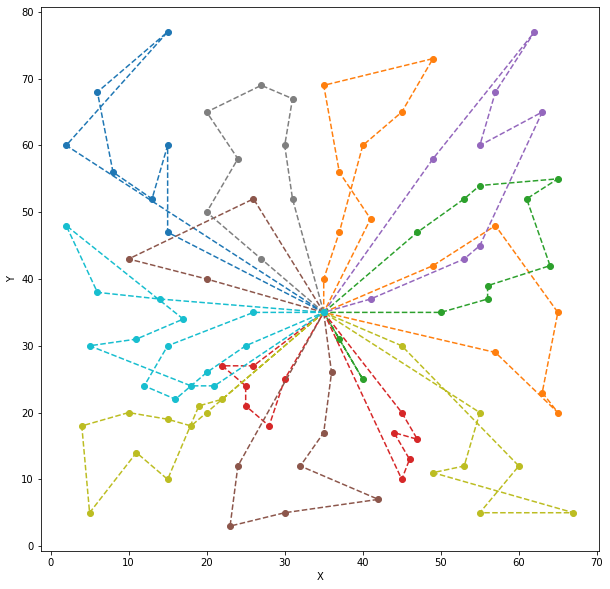

In [23]:
n_vehicles = 20
data, graph, n_locations, n_depots, max_vehicles, max_capacity = create_graph(n_vehicles)
make_plots(routes, graph)